## Housing prices in Boston

The goal is to predict the housing prices in the Boston area.

The data is as follows:
  * `crim` — per capita crime rate by town.
  * `zn` — proportion of residential land zoned for lots over 25,000 sq.ft.
  * `indus` — proportion of non-retail business acres per town.
  * `chas` — Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
  * `nox` — nitrogen oxides concentration (parts per 10 million).
  * `rm` — average number of rooms per dwelling.
  * `age` — proportion of owner-occupied units built prior to 1940.
  * `dis` — weighted mean of distances to five Boston employment centres.
  * `rad` — index of accessibility to radial highways.
  * `tax` — full-value property-tax rate per $10,000.
  * `ptratio` — pupil-teacher ratio by town.
  * `black` — 1000(Bk — 0.63)<sup>2</sup> where Bk is the proportion of blacks by town.
  * `lstat` — lower status of the population (percent).
  * `medv` — median value of owner-occupied homes in \$1000s. **This is the target variable.**

In [47]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType

## spark session

In [48]:
# A SparkSession can be used create DataFrame, register DataFrame as tables, execute SQL over tables, 
# cache tables, and read parquet files. 
spark = SparkSession.builder.appName('houses').getOrCreate()

In [49]:
spark

## Load the Data

In [4]:
bostondf = spark.read.csv(
    '/home/charles/M1/PYTHON_BIG_DATA/exam/boston.csv',
    header = True, # cause columns are named 
    inferSchema = True # infers the input schema automatically from data. It requires one extra
                       # pass over the data.
)

### dataframe schema

In [50]:
bostondf.printSchema()

root
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: integer (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: integer (nullable = true)
 |-- tax: integer (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- black: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)



The column _c0 is not revelant, it is just the identifer user or  somthing similar. Let's drop it. 

In [6]:
bostondf = bostondf.select(
    'crim',
    'zn',
    'indus',
    'chas',
    'nox',
    'rm',
    'age',
    'dis',
    'rad',
    'tax',
    'ptratio',
    'black',
    'lstat',
    'medv'
)

bostondf.printSchema()

root
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: integer (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: integer (nullable = true)
 |-- tax: integer (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- black: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)



## Quick view of the dataframe

In [7]:
bostondf.show(n=3)

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio| black|lstat|medv|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
only showing top 3 rows



##  Output basic stats on the dataset.

In [8]:
bostondf.describe().toPandas().transpose() 
# describe() function compute all the statistic descriptors
# toPandas convert or data to a pandas dataframe so we can use transpose() and have a fancy table
# otherwise we could use : bostondf.describe().show() , but it's sketchy. 

,0,1,2,3,4
summary,count,mean,stddev,min,max
crim,506,3.6135235573122535,8.601545105332491,0.00632,88.9762
zn,506,11.363636363636363,23.32245299451514,0.0,100.0
indus,506,11.136778656126504,6.860352940897589,0.46,27.74
chas,506,0.0691699604743083,0.2539940413404101,0,1
nox,506,0.5546950592885372,0.11587767566755584,0.385,0.871
rm,506,6.284634387351787,0.7026171434153232,3.561,8.78
age,506,68.57490118577078,28.148861406903595,2.9,100.0
dis,506,3.795042687747034,2.10571012662761,1.1296,12.1265
rad,506,9.549407114624506,8.707259384239366,1,24


## Scatter Matrix (use pandas)

Scatter matrix is a great way to roughly determine if we have a linear correlation between multiple independent variables. `pandas` does it for us.


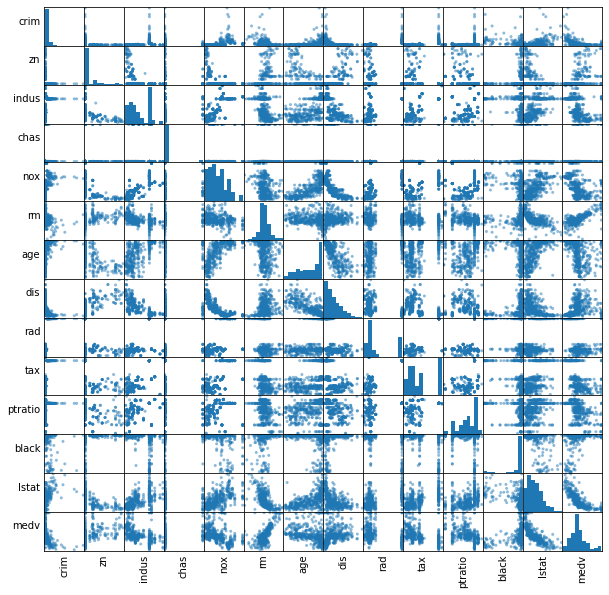

In [9]:
import pandas as pd

numeric_features = [t[0] for t in bostondf.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = bostondf.select(numeric_features).sample(False, 0.8).toPandas()
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)

for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

### Some remarks about the plot

Well, There are a lot of information in this plot. 

We can observe that, medv looks like follow a normal distribution, dis looks like follow an exponentiel distribution, rm also looks like to follow a normal distribution. 

Moreover, we can observe that some variable looks loke to have some linear correlation with the response variable, such as :

- lstat and medv
- rm and medv

## Correlations with the target variable (`medv`)

In [10]:
##help(bostondf.stat)

for col in bostondf.columns :
    print(f"Pearson Correlation Coefficient between {col} and medv is : {bostondf.corr(col, 'medv')}")

Pearson Correlation Coefficient between crim and medv is : -0.38830460858681154
Pearson Correlation Coefficient between zn and medv is : 0.3604453424505433
Pearson Correlation Coefficient between indus and medv is : -0.48372516002837285
Pearson Correlation Coefficient between chas and medv is : 0.17526017719029868
Pearson Correlation Coefficient between nox and medv is : -0.42732077237328203
Pearson Correlation Coefficient between rm and medv is : 0.6953599470715401
Pearson Correlation Coefficient between age and medv is : -0.3769545650045961
Pearson Correlation Coefficient between dis and medv is : 0.249928734085904
Pearson Correlation Coefficient between rad and medv is : -0.38162623063977735
Pearson Correlation Coefficient between tax and medv is : -0.46853593356776674
Pearson Correlation Coefficient between ptratio and medv is : -0.5077866855375623
Pearson Correlation Coefficient between black and medv is : 0.3334608196570662
Pearson Correlation Coefficient between lstat and medv i

## Data preparation

We keep all the variables.
 
` In the cell above, all correlations with the target variable have been compute.`

`The score fluctuate between -1 to 1. `

`When the value is close to 1, it mean there are strong positive correlation between variables`

`When the value is close to -1, this mean a strong negative correlation between the two variables`

`When the value is close to 0, this mean there are a low correlation.`

`Increasing the number of feature, increase the value of r2. Even if a variable hase a small correlation it`     `is still something. A good way to be sure that all the variable are significant for the model is to perform a` `F-test on the model. `

`Another way to evaluate wether or not we should keep some variables, is to compare the adjusted R squared, for` `model with different variables, cause it take into acount the number of predictors. That's why it's a good way` `for determine wether or not we should keep variables`

To prepare the data we need features and labels.
Being that data is numerical, we do not have to perform any encoding. Just build the `Vector`.

In [11]:
from pyspark.ml.feature import VectorAssembler

input_columns = bostondf.drop("medv").columns # cause we do not want the predicitve variable during the training process
features = VectorAssembler(inputCols=input_columns, outputCol='features') 
v_df = features.transform(bostondf)
v_df.show(3)

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+--------------------+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio| black|lstat|medv|            features|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+--------------------+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|[0.00632,18.0,2.3...|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|[0.02731,0.0,7.07...|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|[0.02729,0.0,7.07...|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+--------------------+
only showing top 3 rows



Let's split the dataset into training and testing sets with a 70:30 ratio

In [12]:
splits = v_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

### Implementation of  different classifier

#### Linear regression [docs](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#module-pyspark.ml.regression).


In [13]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(
    featuresCol='features', 
    labelCol='medv',        
    maxIter=10, 
    regParam=0.3,
    elasticNetParam=0.8
)

lr_model = lr.fit(train_df)

### Summary and RMSE

In [17]:
## help(lr_model.summary)

print(f"RMSE (root mean squared error) : {lr_model.summary.rootMeanSquaredError}")  

print(f"r2 (coefficient of determination) : {lr_model.summary.r2}")

RMSE (root mean squared error) : 4.735652427840525
r2 (coefficient of determination) : 0.743433499475697


In [18]:
bostondf.select('medv').describe().show()

+-------+------------------+
|summary|              medv|
+-------+------------------+
|  count|               506|
|   mean|22.532806324110698|
| stddev| 9.197104087379815|
|    min|               5.0|
|    max|              50.0|
+-------+------------------+



RMSE measures the differences between predicted values by the model and the actual values. However, RMSE alone is meaningless until we compare with the actual `medv` value, such as mean, min and max.

Two remarks : 

- r2 is the explanation of the variability of the model, in our case its mean that our model explain 74,34 % of the variability of medv.

- As explain above, RMSE measures the differences between predicted values by the model and the actual values. This involve that RMSE as the same unit as the response variable. medv fluctuate from 5 to 50, RMSE is equal to 4,73. We can conclute that RMSE is not too bad.

### Predictions

In [20]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","medv","features").show(5)

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
|  35.4027554143844|44.0|[0.01538,90.0,3.7...|
| 26.42467068861949|23.1|[0.0187,85.0,4.15...|
|26.232215187817275|33.0|[0.01951,17.5,1.3...|
| 20.59732944158456|20.1|[0.01965,80.0,1.7...|
|  26.2960264826717|26.6|[0.02899,40.0,1.2...|
+------------------+----+--------------------+
only showing top 5 rows



In [27]:
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="medv", metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

R Squared (R2) on test data = 0.643361


In [25]:
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 5.28047


In [28]:
trainingSummary = lr_model.summary 

print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))

trainingSummary.residuals.show()

numIterations: 11
objectiveHistory: [0.5, 0.4309691417672732, 0.22906605633216057, 0.2041728202958176, 0.17140181720214903, 0.1677063019056291, 0.16687454508626312, 0.16567904731852848, 0.16428630885134193, 0.16391716517251914, 0.16385617436601818]
+--------------------+
|           residuals|
+--------------------+
|  -6.581775762783366|
|  1.0496307665753513|
|  -5.643960130122572|
|  0.5919193297362781|
|  4.7195314455193795|
|  1.7667885790709263|
|  11.261621510504128|
|-0.13780625946819214|
| -1.5455663345963373|
| -3.3631593156489927|
|   8.291392215540661|
|  2.9618305017258137|
|  1.2661493757923736|
|  10.226737388718462|
|  -1.695206977289697|
|   5.329405708972786|
|-0.23317760800684795|
|  -9.947706566079063|
|  -4.054719410608758|
|   3.350529911126962|
+--------------------+
only showing top 20 rows



We can use the model to make some predictions on the testing set.

In [29]:
predictions = lr_model.transform(test_df)
predictions.select("prediction", "medv", "features").show(n = 10)

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
|  35.4027554143844|44.0|[0.01538,90.0,3.7...|
| 26.42467068861949|23.1|[0.0187,85.0,4.15...|
|26.232215187817275|33.0|[0.01951,17.5,1.3...|
| 20.59732944158456|20.1|[0.01965,80.0,1.7...|
|  26.2960264826717|26.6|[0.02899,40.0,1.2...|
|29.648805693489244|31.2|[0.03049,55.0,3.7...|
|29.846730761754003|33.4|[0.03237,0.0,2.18...|
|28.132568579553542|24.1|[0.03445,82.5,2.0...|
|30.598288498894163|28.5|[0.03502,80.0,4.9...|
|38.479375647435766|48.5|[0.0351,95.0,2.68...|
+------------------+----+--------------------+
only showing top 10 rows



#### Optimisation using Cross-Validation [doc](https://spark.apache.org/docs/latest/ml-tuning.html#cross-validation)

In [34]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

r2_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="medv", metricName="r2")
rmse_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="medv", metricName="rmse")


In [35]:
paramGrid = (ParamGridBuilder()
             .addGrid(lr.elasticNetParam, [0, 1, 0.8])
             .addGrid(lr.loss, ['squaredError'])
             .addGrid(lr.epsilon, [1.35, 1.75])
             .addGrid(lr.maxIter, [10, 100])
             .addGrid(lr.solver, ['auto','normal', 'l-bfgs'])
            ).build()


cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=rmse_evaluator, numFolds=5)
cvmodel = cv.fit(train_df)
pred = cvmodel.transform(test_df)


print("Root Mean Squared Error (RMSE) on test data = %g" % rmse_evaluator.evaluate(pred))
print("R Squared (R2) on test data = %g" % r2_evaluator.evaluate(pred))

Root Mean Squared Error (RMSE) on test data = 5.07654
R Squared (R2) on test data = 0.670376


We obtain slightly better results, using a gridSearch method.Whatever, it is still better.

### Decision tree regression and Gradient-boosted tree regression [docs](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.regression.DecisionTreeRegressor).

In [36]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol='features',
                           labelCol='medv')

dt_model = dt.fit(train_df)
dt_predictions = dt_model.transform(test_df)

dt_evaluator = RegressionEvaluator(labelCol="medv", predictionCol="prediction", metricName="rmse")


rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print("R Squared (R2) on test data = %g" % r2_evaluator.evaluate(dt_predictions))

Root Mean Squared Error (RMSE) on test data = 5.1089
R Squared (R2) on test data = 0.66616


#### Optimisation using Cross-Validation [doc](https://spark.apache.org/docs/latest/ml-tuning.html#cross-validation)

In [37]:
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [3, 5, 10])
             .addGrid(dt.minInfoGain, [0.0, 0.10, 0.20])
             .addGrid(dt.minInstancesPerNode, [1, 2])
            ).build()


cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=rmse_evaluator, numFolds=5)
cvmodel = cv.fit(train_df)
pred = cvmodel.transform(test_df)


print("Root Mean Squared Error (RMSE) on test data = %g" % rmse_evaluator.evaluate(pred))
print("R Squared (R2) on test data = %g" % r2_evaluator.evaluate(pred))

Root Mean Squared Error (RMSE) on test data = 5.1089
R Squared (R2) on test data = 0.66616


Well, for this one it looks like the default parameters are the best

### Gradient-boosted tree regression [docs](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.regression.GBTRegressor).

In [38]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(featuresCol='features',
                   labelCol='medv')

gbt_model = gbt.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)

gbt_predictions.select('prediction', 'medv', 'features').show(5)


+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
|33.657316589885355|44.0|[0.01538,90.0,3.7...|
|  23.1109978043014|23.1|[0.0187,85.0,4.15...|
|27.943080363901963|33.0|[0.01951,17.5,1.3...|
|20.952576942259828|20.1|[0.01965,80.0,1.7...|
| 30.77567904173942|26.6|[0.02899,40.0,1.2...|
+------------------+----+--------------------+
only showing top 5 rows



In [45]:
gbt_evaluator = RegressionEvaluator(labelCol="medv", predictionCol="prediction", metricName="rmse")

rmse = gbt_evaluator.evaluate(gbt_predictions)

print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print("R Squared (R2) on test data = %g" % r2_evaluator.evaluate(gbt_predictions))

Root Mean Squared Error (RMSE) on test data = 4.65549
R Squared (R2) on test data = 0.722786


#### Optimisation using Cross-Validation [doc](https://spark.apache.org/docs/latest/ml-tuning.html#cross-validation)

In [46]:
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.lossType, ['squared', 'absolute'])
             .addGrid(gbt.maxDepth, [1, 2, 5, 6])
             .addGrid(gbt.maxIter, [15, 20, 30])
            ).build()


cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=rmse_evaluator, numFolds=5)
cvmodel = cv.fit(train_df)
pred = cvmodel.transform(test_df)


print("Root Mean Squared Error (RMSE) on test data = %g" % rmse_evaluator.evaluate(pred))
print("R Squared (R2) on test data = %g" % r2_evaluator.evaluate(pred))

Root Mean Squared Error (RMSE) on test data = 4.65764
R Squared (R2) on test data = 0.72253


### Results 
Base on the RMSE measure the best classifier are :
- First gbt with RMSE = 4.65
- Second lr with RMSE = 5.07
- Third dt with RMSE = 5.10